# Predicción de Series Temporales con StatsForecast (Auto ARIMA)

Este notebook muestra cómo usar la librería `statsforecast` y su función `AutoARIMA()` para realizar predicción automática de series temporales. StatsForecast es una librería moderna, más rápida y compatible con las últimas versiones de Python y NumPy.

## 1. Instalación e Importación de Librerías

In [1]:
# Instalar statsforecast (compatible con Google Colab)
!pip install statsforecast -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## 2. Cargar Datos de Ejemplo

Usaremos el dataset clásico de pasajeros de aerolíneas (AirPassengers).

In [3]:
# Cargar datos desde una URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)

# Renombrar columnas para claridad
df.columns = ['ds', 'y']

# Convertir la columna de fecha
df['ds'] = pd.to_datetime(df['ds'])

# Añadir columna de identificador de serie (requerido por StatsForecast)
df['unique_id'] = 'AirPassengers'

# Reordenar columnas (formato requerido: unique_id, ds, y)
df = df[['unique_id', 'ds', 'y']]

print(f"Forma de los datos: {df.shape}")
print("\nPrimeras observaciones:")
print(df.head(10))
print("\nÚltimas observaciones:")
print(df.tail(5))

Forma de los datos: (144, 3)

Primeras observaciones:
       unique_id         ds    y
0  AirPassengers 1949-01-01  112
1  AirPassengers 1949-02-01  118
2  AirPassengers 1949-03-01  132
3  AirPassengers 1949-04-01  129
4  AirPassengers 1949-05-01  121
5  AirPassengers 1949-06-01  135
6  AirPassengers 1949-07-01  148
7  AirPassengers 1949-08-01  148
8  AirPassengers 1949-09-01  136
9  AirPassengers 1949-10-01  119

Últimas observaciones:
         unique_id         ds    y
139  AirPassengers 1960-08-01  606
140  AirPassengers 1960-09-01  508
141  AirPassengers 1960-10-01  461
142  AirPassengers 1960-11-01  390
143  AirPassengers 1960-12-01  432


## 3. Visualización de la Serie Temporal

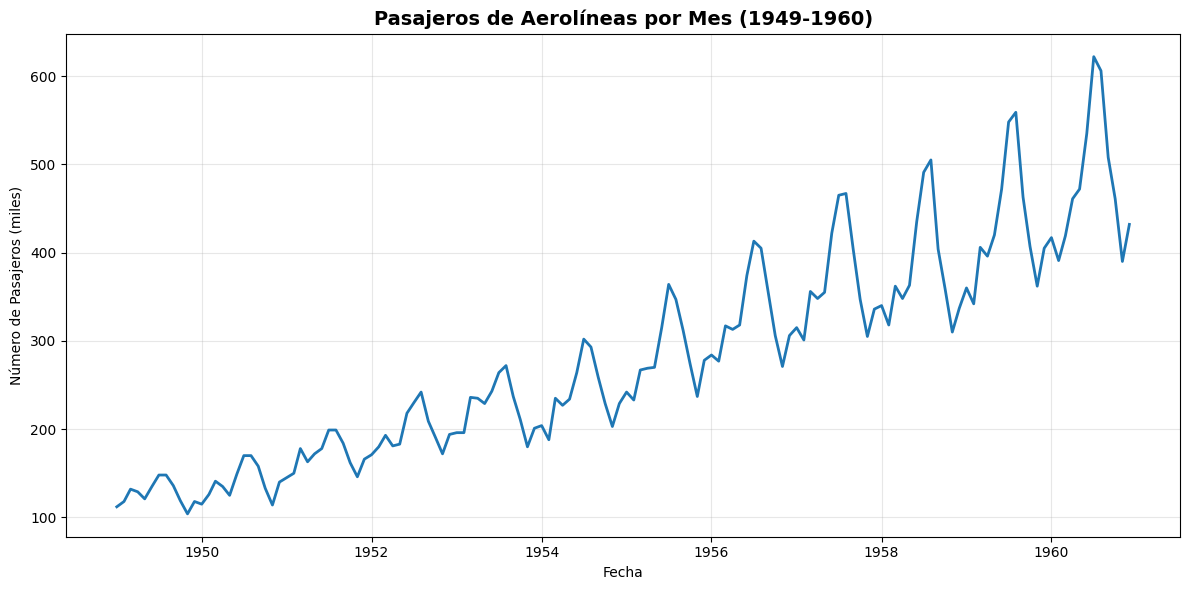

In [4]:
# Visualizar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], linewidth=2)
plt.title('Pasajeros de Aerolíneas por Mes (1949-1960)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros (miles)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Dividir en Conjuntos de Entrenamiento y Prueba

In [5]:
# Dividir los datos: 80% entrenamiento, 20% prueba
train_size = int(len(df) * 0.8)
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()

print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")
print(f"\nFecha inicial entrenamiento: {train_df['ds'].min()}")
print(f"Fecha final entrenamiento: {train_df['ds'].max()}")
print(f"Fecha inicial prueba: {test_df['ds'].min()}")
print(f"Fecha final prueba: {test_df['ds'].max()}")

Tamaño del conjunto de entrenamiento: 115
Tamaño del conjunto de prueba: 29

Fecha inicial entrenamiento: 1949-01-01 00:00:00
Fecha final entrenamiento: 1958-07-01 00:00:00
Fecha inicial prueba: 1958-08-01 00:00:00
Fecha final prueba: 1960-12-01 00:00:00


## 5. Configurar y Entrenar el Modelo AutoARIMA

`AutoARIMA()` de StatsForecast busca automáticamente los mejores parámetros (p, d, q) y (P, D, Q, s) para el modelo ARIMA/SARIMA.

### Parámetros importantes:
- `season_length=12`: Periodo estacional (12 meses)
- `approximation=False`: Búsqueda exhaustiva (más precisa pero más lenta)
- `stepwise=True`: Búsqueda stepwise (más rápida)

### Ventajas de StatsForecast:
- **Hasta 20x más rápido** que pmdarima
- **Compatible** con NumPy 2.x y Python 3.12
- **Múltiples series** a la vez
- **Intervalos de predicción** automáticos

In [6]:
# Configurar el modelo AutoARIMA
print("Configurando y entrenando el modelo AutoARIMA...")
print("=" * 60)

# Crear el modelo
models = [
    AutoARIMA(season_length=12)  # Periodo estacional mensual
]

# Crear el objeto StatsForecast
sf = StatsForecast(
    models=models,
    freq='MS',  # Frecuencia mensual (Month Start)
    n_jobs=-1   # Usar todos los cores disponibles
)

# Entrenar el modelo
sf.fit(train_df)

print("\n" + "=" * 60)
print("Modelo AutoARIMA entrenado exitosamente!")

Configurando y entrenando el modelo AutoARIMA...

✅ Modelo AutoARIMA entrenado exitosamente!


In [53]:
# Obtener los parámetros del modelo ajustado
print("PARÁMETROS DEL MODELO AUTOARIMA AJUSTADO")

# Acceder al modelo entrenado
fitted_model = sf.fitted_[0, 0]

# Extraer parámetros del campo 'arma'
# El formato es: (p, q, P, Q, periodo, d, D)
arma_params = fitted_model.model_['arma']
p, q, P, Q, s, d, D = arma_params

print(f"\n Orden del modelo ARIMA:")
print(f"   p (AR - AutoRegresivo):     {p}")
print(f"   d (Diferenciación):         {d}")
print(f"   q (MA - Media Móvil):       {q}")

print(f"\n Orden estacional:")
print(f"   P (SAR - Estacional AR):    {P}")
print(f"   D (Diferenciación estac.):  {D}")
print(f"   Q (SMA - Estacional MA):    {Q}")
print(f"   s (Periodo estacional):     {s}")

print(f"\nModelo completo: ARIMA({p},{d},{q})({P},{D},{Q})[{s}]")



PARÁMETROS DEL MODELO AUTOARIMA AJUSTADO

 Orden del modelo ARIMA:
   p (AR - AutoRegresivo):     1
   d (Diferenciación):         1
   q (MA - Media Móvil):       0

 Orden estacional:
   P (SAR - Estacional AR):    0
   D (Diferenciación estac.):  1
   Q (SMA - Estacional MA):    0
   s (Periodo estacional):     12

Modelo completo: ARIMA(1,1,0)(0,1,0)[12]


In [54]:
# Información adicional del modelo
print(f"\nCriterios de información:")
print(f"   AIC (Akaike):               {fitted_model.model_['aic']:.2f}")
print(f"   AICc (Akaike corregido):    {fitted_model.model_['aicc']:.2f}")
print(f"   BIC (Bayesiano):            {fitted_model.model_['bic']:.2f}")

print(f"\nOtras estadísticas:")
print(f"   Sigma² (varianza residual): {fitted_model.model_['sigma2']:.2f}")
print(f"   Log-likelihood:             {fitted_model.model_['loglik']:.2f}")
print(f"   Número de observaciones:    {fitted_model.model_['nobs']}")

# Mostrar coeficientes
print(f"\nCoeficientes del modelo:")
for coef_name, coef_value in fitted_model.model_['coef'].items():
    print(f"   {coef_name}: {coef_value:.6f}")

print("\n" + "=" * 60)


Criterios de información:
   AIC (Akaike):               755.50
   AICc (Akaike corregido):    755.62
   BIC (Bayesiano):            760.75

Otras estadísticas:
   Sigma² (varianza residual): 93.62
   Log-likelihood:             -375.75
   Número de observaciones:    102

Coeficientes del modelo:
   ar1: -0.206289



## 6. Realizar Predicciones sobre el Conjunto de Prueba

In [9]:
# Hacer predicciones con intervalos de confianza
n_periods = len(test_df)

# Predecir con niveles de confianza
predictions = sf.predict(h=n_periods, level=[95])

# Resetear índice para facilitar el merge
predictions = predictions.reset_index()

# Combinar con datos reales
results_df = test_df.merge(predictions, on=['unique_id', 'ds'], how='left')

print(results_df.head(10))


       unique_id         ds    y  index   AutoARIMA  AutoARIMA-lo-95  \
0  AirPassengers 1958-08-01  505      0  490.318237       471.354401   
1  AirPassengers 1958-09-01  404      1  427.871460       403.660217   
2  AirPassengers 1958-10-01  359      2  370.757355       341.814545   
3  AirPassengers 1958-11-01  310      3  328.780884       295.857697   
4  AirPassengers 1958-12-01  337      4  359.776031       323.289520   
5  AirPassengers 1959-01-01  360      5  363.777039       324.048309   
6  AirPassengers 1959-02-01  342      6  341.776825       299.050690   
7  AirPassengers 1959-03-01  406      7  385.776855       340.250336   
8  AirPassengers 1959-04-01  396      8  371.776855       323.612457   
9  AirPassengers 1959-05-01  420      9  386.776855       336.111755   

   AutoARIMA-hi-95  
0       509.282074  
1       452.082703  
2       399.700134  
3       361.704071  
4       396.262512  
5       403.505737  
6       384.502960  
7       431.303375  
8       419.941254

In [11]:
# Renombrar columnas para claridad
results_df = results_df.rename(columns={
    'y': 'Real',
    'AutoARIMA': 'Predicción',
    'AutoARIMA-lo-95': 'IC_Inferior',
    'AutoARIMA-hi-95': 'IC_Superior'
})

print("Predicciones vs Valores Reales:")
print(results_df[['ds', 'Real', 'Predicción', 'IC_Inferior', 'IC_Superior']].head(10))

Predicciones vs Valores Reales:
          ds  Real  Predicción  IC_Inferior  IC_Superior
0 1958-08-01   505  490.318237   471.354401   509.282074
1 1958-09-01   404  427.871460   403.660217   452.082703
2 1958-10-01   359  370.757355   341.814545   399.700134
3 1958-11-01   310  328.780884   295.857697   361.704071
4 1958-12-01   337  359.776031   323.289520   396.262512
5 1959-01-01   360  363.777039   324.048309   403.505737
6 1959-02-01   342  341.776825   299.050690   384.502960
7 1959-03-01   406  385.776855   340.250336   431.303375
8 1959-04-01   396  371.776855   323.612457   419.941254
9 1959-05-01   420  386.776855   336.111755   437.441956


## 7. Visualizar Predicciones

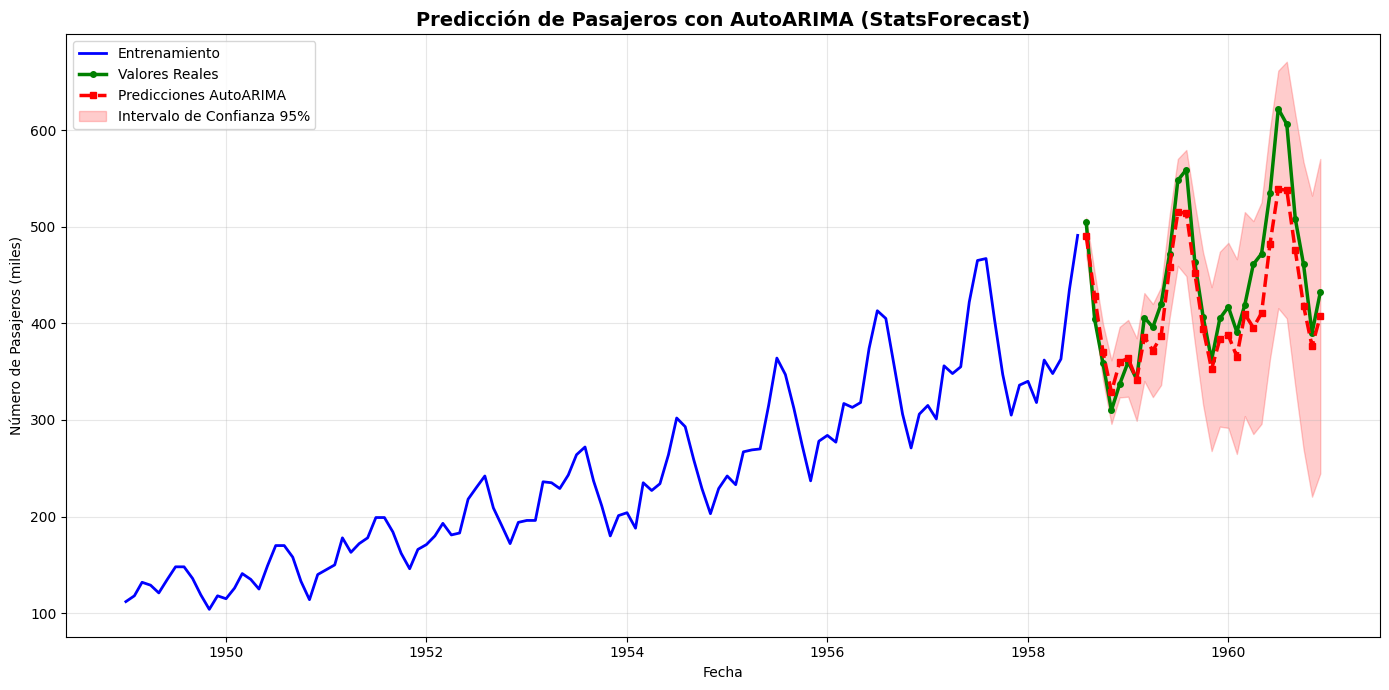

In [12]:
# Visualizar resultados
plt.figure(figsize=(14, 7))

# Serie de entrenamiento
plt.plot(train_df['ds'], train_df['y'], label='Entrenamiento', color='blue', linewidth=2)

# Serie de prueba (valores reales)
plt.plot(results_df['ds'], results_df['Real'], label='Valores Reales',
         color='green', linewidth=2.5, marker='o', markersize=4)

# Predicciones
plt.plot(results_df['ds'], results_df['Predicción'], label='Predicciones AutoARIMA',
         color='red', linewidth=2.5, linestyle='--', marker='s', markersize=4)

# Intervalo de confianza
plt.fill_between(results_df['ds'],
                 results_df['IC_Inferior'],
                 results_df['IC_Superior'],
                 alpha=0.2, color='red', label='Intervalo de Confianza 95%')

plt.title('Predicción de Pasajeros con AutoARIMA (StatsForecast)',
          fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros (miles)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Evaluación del Modelo

In [13]:
# Calcular métricas de error
y_true = results_df['Real'].values
y_pred = results_df['Predicción'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nMétricas de Evaluación:")
print("=" * 40)
print(f"MSE (Error Cuadrático Medio):  {mse:.2f}")
print(f"RMSE (Raíz del ECM):           {rmse:.2f}")
print(f"MAE (Error Absoluto Medio):    {mae:.2f}")
print(f"MAPE (Error % Absoluto Medio): {mape:.2f}%")

# Calcular cobertura del intervalo de confianza
within_interval = ((y_true >= results_df['IC_Inferior']) &
                   (y_true <= results_df['IC_Superior'])).sum()
coverage = (within_interval / len(y_true)) * 100

print(f"\nCobertura del IC 95%:          {coverage:.1f}%")
print(f"(Valores reales dentro del intervalo: {within_interval}/{len(y_true)})")


Métricas de Evaluación:
MSE (Error Cuadrático Medio):  1232.22
RMSE (Raíz del ECM):           35.10
MAE (Error Absoluto Medio):    28.57
MAPE (Error % Absoluto Medio): 6.13%

Cobertura del IC 95%:          100.0%
(Valores reales dentro del intervalo: 29/29)


## 9. Predicciones Futuras

Ahora vamos a hacer predicciones para el futuro (más allá de nuestros datos).

In [14]:
# Reentrenar el modelo con todos los datos
print("Reentrenando con todos los datos para predicciones futuras...")

sf_final = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='MS',
    n_jobs=-1
)

sf_final.fit(df)

# Predecir los próximos 24 meses
future_periods = 24
future_predictions = sf_final.predict(h=future_periods, level=[80, 95])

# Resetear índice
future_predictions = future_predictions.reset_index()

print(f"\n✅ Predicciones generadas para los próximos {future_periods} meses")
print("\nPrimeras 12 predicciones:")
print(future_predictions[['ds', 'AutoARIMA', 'AutoARIMA-lo-95', 'AutoARIMA-hi-95']].head(12))

Reentrenando con todos los datos para predicciones futuras...

✅ Predicciones generadas para los próximos 24 meses

Primeras 12 predicciones:
           ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0  1961-01-01  444.309570       421.279327       467.339813
1  1961-02-01  418.213745       390.227631       446.199829
2  1961-03-01  446.243408       412.910034       479.576782
3  1961-04-01  488.234222       450.621368       525.847107
4  1961-05-01  499.237061       457.694824       540.779297
5  1961-06-01  562.236206       517.130981       607.341431
6  1961-07-01  649.236450       600.822449       697.650513
7  1961-08-01  633.236389       581.727783       684.744934
8  1961-09-01  535.236389       480.808289       589.664490
9  1961-10-01  488.236389       431.037781       545.434998
10 1961-11-01  417.236389       357.395325       477.077454
11 1961-12-01  459.236389       396.864746       521.608032


## 10. Visualizar Predicciones Futuras

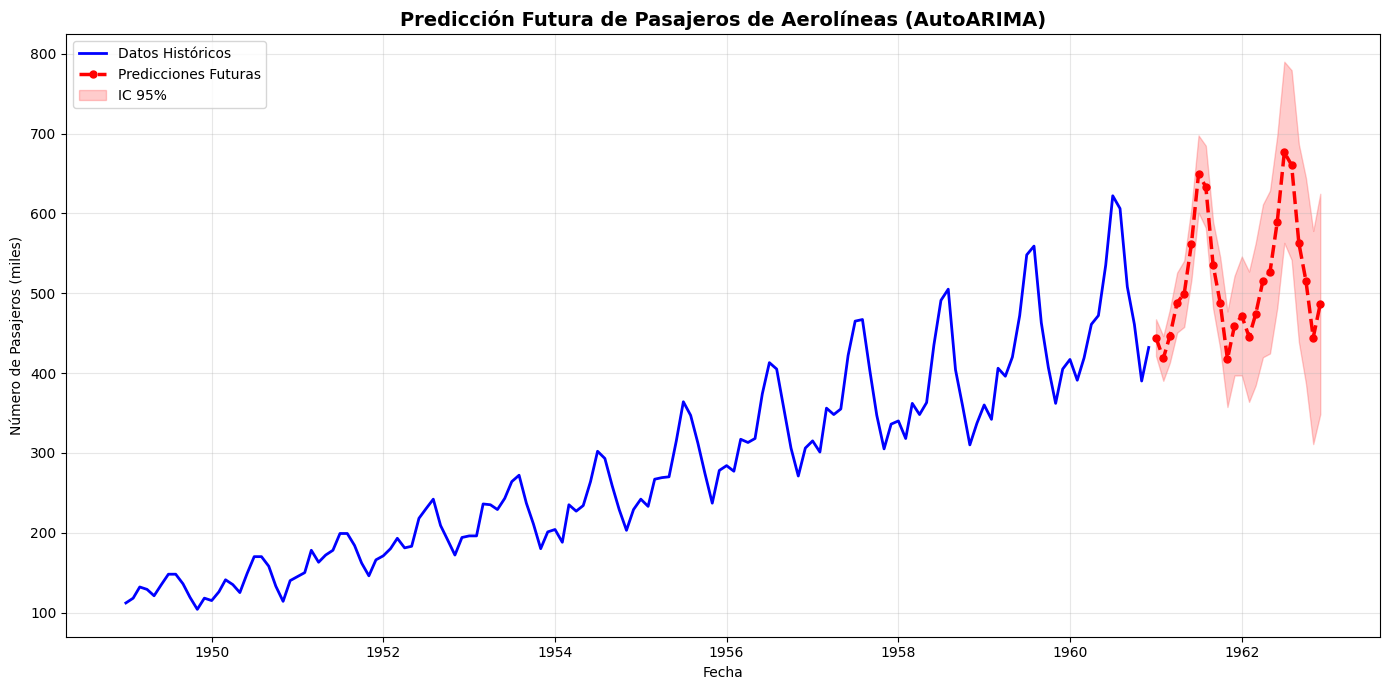

In [17]:
# Visualizar predicciones futuras
plt.figure(figsize=(14, 7))

# Datos históricos
plt.plot(df['ds'], df['y'], label='Datos Históricos', color='blue', linewidth=2)

# Predicciones futuras
plt.plot(future_predictions['ds'], future_predictions['AutoARIMA'],
         label='Predicciones Futuras', color='red', linewidth=2.5,
         linestyle='--', marker='o', markersize=5)

# Intervalo de confianza 95%
plt.fill_between(future_predictions['ds'],
                 future_predictions['AutoARIMA-lo-95'],
                 future_predictions['AutoARIMA-hi-95'],
                 alpha=0.2, color='red', label='IC 95%')

# # Intervalo de confianza 80%
# plt.fill_between(future_predictions['ds'],
#                  future_predictions['AutoARIMA-lo-80'],
#                  future_predictions['AutoARIMA-hi-80'],
#                  alpha=0.3, color='orange', label='IC 80%')

plt.title('Predicción Futura de Pasajeros de Aerolíneas (AutoARIMA)',
          fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros (miles)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Análisis de Componentes de la Serie (Descomposición)

Analicemos los componentes de la serie temporal: tendencia, estacionalidad y residuos.

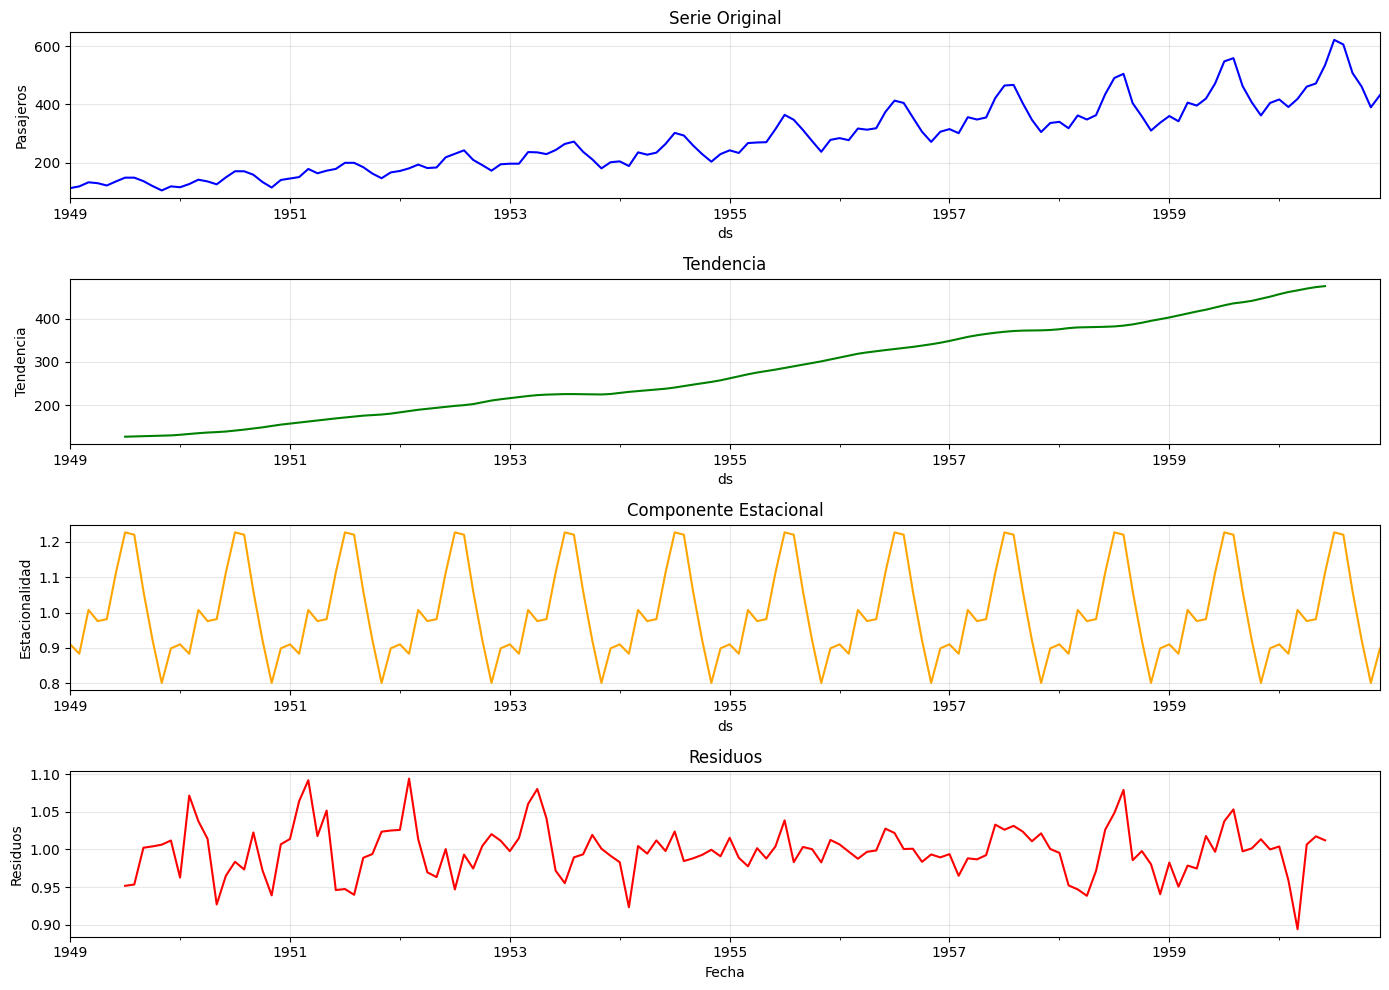

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizar descomposición
# Convertir a serie temporal con índice de fechas
ts_data = df.set_index('ds')['y']

# Descomposición multiplicativa (apropiada para esta serie)
decomposition = seasonal_decompose(ts_data, model='multiplicative', period=12)

# Visualizar componentes
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Serie original
decomposition.observed.plot(ax=axes[0], title='Serie Original', color='blue')
axes[0].set_ylabel('Pasajeros')
axes[0].grid(True, alpha=0.3)

# Tendencia
decomposition.trend.plot(ax=axes[1], title='Tendencia', color='green')
axes[1].set_ylabel('Tendencia')
axes[1].grid(True, alpha=0.3)

# Estacionalidad
decomposition.seasonal.plot(ax=axes[2], title='Componente Estacional', color='orange')
axes[2].set_ylabel('Estacionalidad')
axes[2].grid(True, alpha=0.3)

# Residuos
decomposition.resid.plot(ax=axes[3], title='Residuos', color='red')
axes[3].set_ylabel('Residuos')
axes[3].set_xlabel('Fecha')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Comparación con Otros Modelos

StatsForecast permite entrenar múltiples modelos a la vez y compararlos fácilmente.

In [19]:
from statsforecast.models import AutoETS, Naive, SeasonalNaive

# Configurar múltiples modelos
models_comparison = [
    AutoARIMA(season_length=12),
    AutoETS(season_length=12),
    SeasonalNaive(season_length=12),
    Naive()
]

# Crear objeto StatsForecast con múltiples modelos
sf_multi = StatsForecast(
    models=models_comparison,
    freq='MS',
    n_jobs=-1
)

# Entrenar con datos de entrenamiento
sf_multi.fit(train_df)

# Predecir
predictions_multi = sf_multi.predict(h=len(test_df))
predictions_multi = predictions_multi.reset_index()

print("✅ Modelos entrenados y predicciones generadas")
print("\nPrimeras predicciones de cada modelo:")
print(predictions_multi.head())

✅ Modelos entrenados y predicciones generadas

Primeras predicciones de cada modelo:
   index      unique_id         ds   AutoARIMA     AutoETS  SeasonalNaive  \
0      0  AirPassengers 1958-08-01  490.318237  466.258667          467.0   
1      1  AirPassengers 1958-09-01  427.871460  411.800079          404.0   
2      2  AirPassengers 1958-10-01  370.757355  358.573029          347.0   
3      3  AirPassengers 1958-11-01  328.780884  309.565063          305.0   
4      4  AirPassengers 1958-12-01  359.776031  349.246368          336.0   

   Naive  
0  491.0  
1  491.0  
2  491.0  
3  491.0  
4  491.0  


In [20]:
# Calcular métricas para cada modelo
y_true = test_df['y'].values

models_metrics = {}
for model_name in ['AutoARIMA', 'AutoETS', 'SeasonalNaive', 'Naive']:
    y_pred = predictions_multi[model_name].values

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    models_metrics[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Crear DataFrame con métricas
metrics_df = pd.DataFrame(models_metrics).T
metrics_df = metrics_df.round(2)

print("\nComparación de Modelos:")
print("=" * 50)
print(metrics_df)

# Encontrar el mejor modelo
best_model = metrics_df['RMSE'].idxmin()
print(f"\n🏆 Mejor modelo según RMSE: {best_model}")


Comparación de Modelos:
                RMSE    MAE   MAPE
AutoARIMA      35.10  28.57   6.13
AutoETS        68.87  55.65  11.73
SeasonalNaive  75.23  64.76  14.04
Naive          93.13  81.45  20.20

🏆 Mejor modelo según RMSE: AutoARIMA


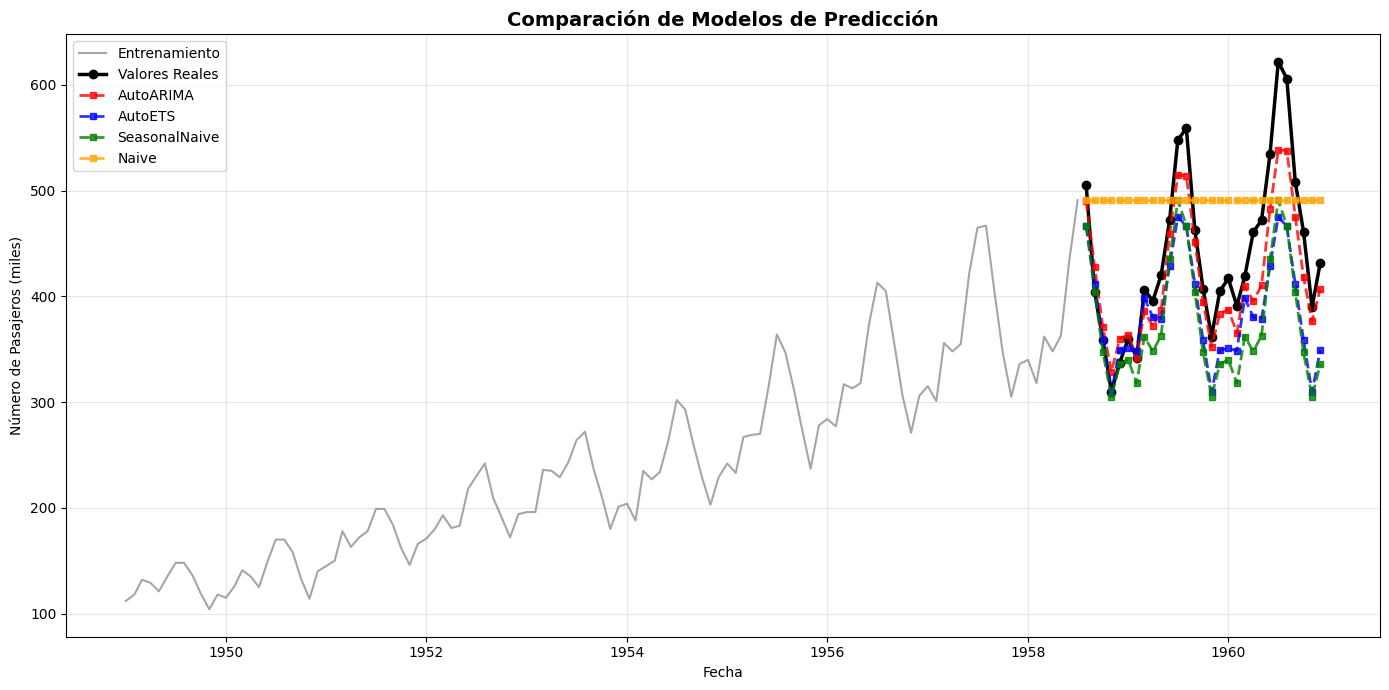

In [21]:
# Visualizar comparación de modelos
plt.figure(figsize=(14, 7))

# Datos reales
plt.plot(train_df['ds'], train_df['y'], label='Entrenamiento', color='gray', linewidth=1.5, alpha=0.7)
plt.plot(test_df['ds'], test_df['y'], label='Valores Reales', color='black', linewidth=2.5, marker='o')

# Predicciones de cada modelo
colors = ['red', 'blue', 'green', 'orange']
for i, model_name in enumerate(['AutoARIMA', 'AutoETS', 'SeasonalNaive', 'Naive']):
    plt.plot(predictions_multi['ds'], predictions_multi[model_name],
             label=f'{model_name}', color=colors[i], linewidth=2,
             linestyle='--', marker='s', markersize=4, alpha=0.8)

plt.title('Comparación de Modelos de Predicción', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros (miles)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusión

Este notebook ha demostrado cómo usar `StatsForecast` y `AutoARIMA()` para:

### Características principales:
1. **Búsqueda automática** de los mejores parámetros ARIMA/SARIMA
2. **Predicciones con intervalos de confianza** (múltiples niveles)
3. **Evaluación del modelo** con métricas estándar
4. **Predicciones futuras** con incertidumbre cuantificada
5. **Descomposición de series** temporales
6. **Comparación de múltiples modelos** simultáneamente

### Ventajas de StatsForecast:
- **Velocidad**: Hasta 20x más rápido que pmdarima
- **Compatibilidad**: Funciona con NumPy 2.x y Python 3.12+
- **Escalabilidad**: Puede procesar múltiples series a la vez
- **Facilidad de uso**: API simple e intuitiva
- **Producción**: Optimizado para entornos de producción

### Recursos adicionales:
- Documentación oficial: https://nixtla.github.io/statsforecast/
- GitHub: https://github.com/Nixtla/statsforecast
- Tutoriales: https://nixtla.github.io/statsforecast/examples.html